In [23]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt
import pickle

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
sns.set_style('whitegrid')

In [24]:

pickle_in = open("pickle/X.pickle", "rb")
image_data = pickle.load(pickle_in)
pickle_in = open("pickle/y.pickle", "rb")
labels = pickle.load(pickle_in)




In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=100)


In [26]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
   #  soft margin và  hard margin
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        loss += 0.5*np.dot(W,W.T) #T chuyển vị 
        m = X.shape[0] # số dòng dữ liệu mẫu
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))

        return loss[0][0]

    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):

        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        print(no_of_samples)

        n = learning_rate
        c = self.C
        #khởi tạo các tham số mô hình
        W = np.zeros((1,no_of_features))
        bias = 0
        #Mất mát ban đầu
        #Training from here...
        # Weight and Bias cập nhật
        losses = []

        for i in range(maxItr):
            #Vòng lặp đào tạo

            l = self.hingeLoss(W,bias,X,Y) #mất mát
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids) #xáo trộn các giá trị mảng

            #Mini-Batch Gradient Descent với random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0

                #với 1 mini batch gồm 50 dòng dữ liệu
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)

                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]

                #Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
        self.W = W
        self.b = bias
        return W,bias,losses

In [27]:
## Chuyển đổi dữ liệu cho phân loại Một vs Một 

M = X_train.shape[0]
X_train = X_train.reshape(M,-1)

print(X_train.shape)
print(type(X_train.shape))
print(labels.shape)

#test
M1 = X_test.shape[0]
X_test = X_test.reshape(M1,-1)

(4796, 3072)
<class 'tuple'>
(5995,)


In [28]:
number_of_classes = len(np.unique(labels))
number_of_classes

3

In [29]:
#tạo Dictionary với key là label, là 0,1,2,3 và value là toàn bộ mảng Xi -> label đó
def classWiseData(x, y):
    data = {}

    for i in range(number_of_classes):
        data[i] = []

    for i in range(x.shape[0]):
        data[y[i]].append(x[i])

    for k in data.keys():
        data[k] = np.array(data[k])

    return data

In [30]:
data = classWiseData(X_train, y_train)
print(type(data))

print(data[0].shape[0])
print(data[1].shape[0])
print(data[2].shape[0])
# print(data[3].shape[0])


<class 'dict'>
1659
1601
1536


In [31]:
#Kết hợp dữ liệu của hai lớp thành một ma trận duy nhất X,y 
def getDataPairForSVM(d1,d2):

    l1,l2 = d1.shape[0], d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]
    #tạo một mảng với số dòng bằng dòng = 2 tập dữ liệu cộng lại
    #cột bằng số tính năng, đặc điểm của tập dữ liệu,vì 2 tập có số tính năng là
    #như nhau nên chỉ cần lấy độ lớn của 1 tập
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))

    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2

    data_labels[:l1] = -1
    data_labels[l1:] = 1

    return data_pair, data_labels

In [32]:
#Training SVM
mySVM = SVM()


In [33]:
# với one vs one (NumClasses * (NumClasses – 1)) / 2 = (3*(3-1)/2= 3 cặp
def trainSVMs(x,y):
    svm_classifiers = {}

    for i in range(number_of_classes):
        svm_classifiers[i] = {}
        for j in range(i+1, number_of_classes):
            # print("data[",i,"] và data[",j,"]")
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair, ypair,learning_rate=0.00001,maxItr=1500)
            svm_classifiers[i][j] = (wts,b)
            name_plot = "plot_loss_"+str(i)+"-"+str(j)
            plt.plot(loss)
            plt.savefig("imagemodels/"+name_plot,dpi=150)
            plt.show()

    return svm_classifiers

3260


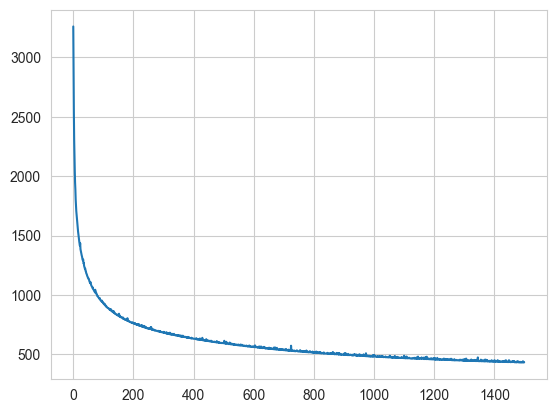

3195


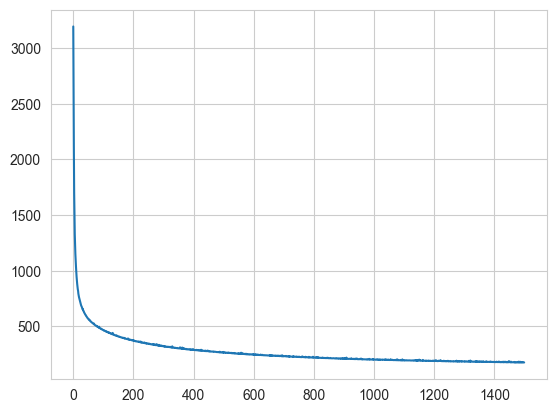

3137


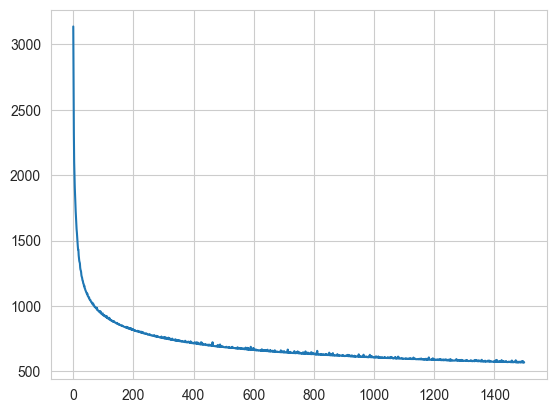

In [34]:
svm_classifiers = trainSVMs(X_train, X_test)

pickle.dump(svm_classifiers,open("models/svm_build.pkl","wb"))

In [36]:
incorrect_withmask = svm_classifiers[0][1]
#cats_humans = svm_classifiers[0][3]
print("kích thước mảng tham số cho incorrect_withmask",incorrect_withmask[0].shape)
print("bias",incorrect_withmask[1])

kích thước mảng tham số cho incorrect_withmask (1, 3072)
bias 0.6800899999999791


In [37]:
#Prediction
def binaryPredict(x,w,b):
    z = np.dot(x,w.T) + b
    
    if z >= 0:
        return 1
    else:
        return -1

def predict(x):
    count = np.zeros((number_of_classes,)) #cat dog 1 
    for i in range(number_of_classes):
        for j in range(i+1, number_of_classes):
            w,b = svm_classifiers[i][j]
            #
            z = binaryPredict(x,w,b)
            #(lớp có tổng điểm lớn nhất) được dự đoán là nhãn lớp.
            if z==1:
                count[j] += 1
            else:
                count[i] += 1

    final_prediction = np.argmax(count)
    return final_prediction

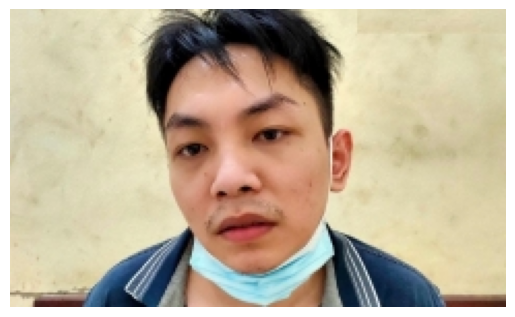

0
dự đoán: IncorrectlyWornMask


In [38]:
switcher = { 0 : 'IncorrectlyWornMask',1 :'WithMask', 2 :'WithoutMask'}


imgshow = image.load_img("imgthucte/incorrect2.jpeg")
plt.imshow(imgshow)
plt.axis('off')
plt.show()
imgpre = image.load_img("imgthucte/incorrect2.jpeg", target_size=(32,32))
imgpre_array = image.img_to_array(imgpre)
imgpre_array = np.array(imgpre_array, dtype='float32')/255.0
imgpre_array = imgpre_array.reshape(-1,)

# print(imgpre_array)
pre1 = predict(imgpre_array)
print(pre1)

print("dự đoán:",switcher.get(pre1, "nothing"))

In [39]:
def accuracy(x,y):
    pred = []
    count=0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        pred.append(prediction)
        if prediction==y[i]:
            count += 1
    return count/x.shape[0], pred

In [40]:
acc, ypred = accuracy(X_test, y_test)
acc
# print("chất lượng của hàm dự đoán tự viết: ",acc)

0.8824020016680567

In [41]:
#Using scikit
from sklearn import svm
svm_classifier = svm.SVC(kernel='poly', C=1.0, probability=True)
svm_classifier.fit(X_train, y_train)
pickle.dump(svm_classifier,open("models/svm_sklearn.pkl","wb"))
type(X_train)

numpy.ndarray

In [42]:
ypred_sklearn = svm_classifier.predict(X_test)
print("chất lượng khi dùng thư viện Sklearn: ",svm_classifier.score(X_test,y_test))

chất lượng khi dùng thư viện Sklearn:  0.8924103419516264


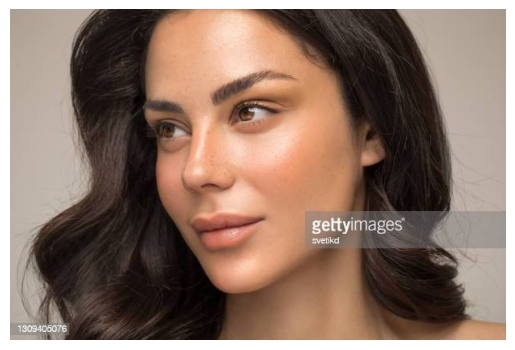

[2]
dự đoán: WithoutMask


In [43]:


imgshow = image.load_img("imgthucte/gettyimages-1309405076-612x612.jpeg")
plt.imshow(imgshow)
plt.axis('off')
plt.show()
imgpre = image.load_img("imgthucte/gettyimages-1309405076-612x612.jpeg", target_size=(32,32))
imgpre_array = image.img_to_array(imgpre)
imgpre_array = np.array(imgpre_array, dtype='float32')/255.0
imgpre_array = imgpre_array.reshape(-1,)

pre2 = svm_classifier.predict([imgpre_array])

switcher = { 0 : 'IncorrectlyWornMask',1 :'WithMask', 2 :'WithoutMask'}

print(pre2)
print("dự đoán:",switcher.get(pre2[0], "nothing"))

SVM classifier


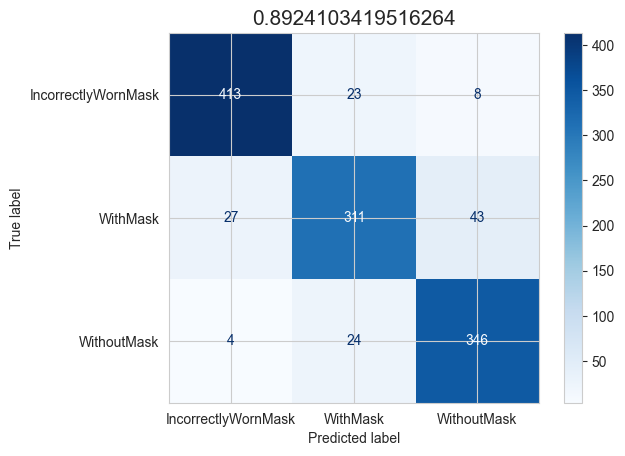

In [44]:
#Ma trận nhầm lẫn- Confusion Matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,roc_auc_score

# plot_confusion_matrix
class_names = ['IncorrectlyWornMask', 'WithMask','WithoutMask']
print("SVM classifier")
cnf_matrix = confusion_matrix(y_test, ypred_sklearn)
disp = ConfusionMatrixDisplay(cnf_matrix,display_labels = class_names)
disp.plot(cmap="Blues")
plt.savefig("imagemodels/SVM_seft_confusion.png",dpi=120)
all_sample_title = accuracy_score(y_test, ypred_sklearn)
plt.title(all_sample_title,size=15)
plt.show()
#lưu hình ảnh để cho lên giao diện



SVM classifier
[[393  41  10]
 [ 28 313  40]
 [  4  18 352]]


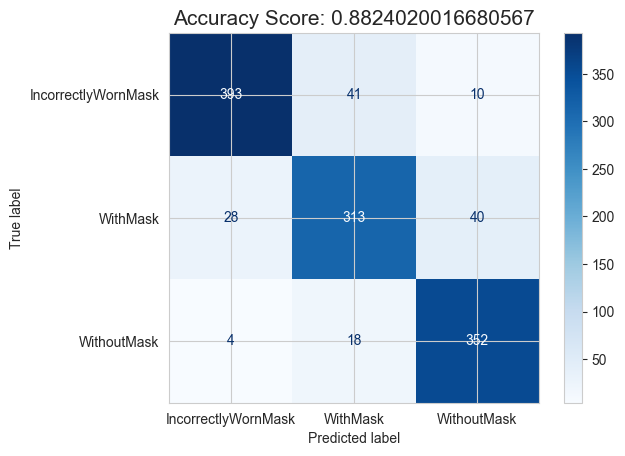

In [45]:
# Calculate Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay


# plot_confusion_matrix
class_names = ['IncorrectlyWornMask', 'WithMask','WithoutMask']
print("SVM classifier")
cnf_matrix = confusion_matrix(y_test, ypred)
print(cnf_matrix)
disp = ConfusionMatrixDisplay(cnf_matrix,display_labels = class_names)
disp.plot(cmap="Blues")
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, ypred))
plt.title(all_sample_title,size=15)
plt.savefig("imagemodels/SVM_confusion.png",dpi=120)
plt.show()

In [46]:
print("Sci-kit Learn")
# plot_confusion_matrix(svm_classifier, image_data_test, labels_test, display_labels=class_names)
#lưu hình ảnh để cho lên giao diện
plt.savefig("imagemodels\cfm_sklearn.png",dpi=120)


Sci-kit Learn


<Figure size 640x480 with 0 Axes>

In [47]:

# #mô hình svm tự xây dựng
acc_build = accuracy_score(y_test,ypred)
precision_build = precision_score(y_test,ypred, average='macro')
recall_build = recall_score(y_test,ypred, average='macro')
f1_build = f1_score(y_test,ypred, average='macro')
pickle.dump([acc_build,precision_build,recall_build,f1_build],open("models/seft_svm_quality.pkl","wb"))



# #mô hình svm sử dụng thư viện sklearn
acc_library = accuracy_score(y_test,ypred_sklearn)
precision_library = precision_score(y_test,ypred_sklearn, average='macro')
recall_library = recall_score(y_test,ypred_sklearn, average='macro')
f1_library = f1_score(y_test,ypred_sklearn, average='macro')
pickle.dump([acc_library,precision_library,recall_library,f1_library],open("models/svm_quality.pkl","wb"))


df_compare = pd.DataFrame({
    'Accuracy':[acc_build,acc_library],
    'Precision score': [precision_build,precision_library],
    'Recall score': [recall_build,recall_library],
    'F1 score': [f1_build,f1_library]

})
df_compare.index = ['Self-built SVM model','Model SVM library' ]
pickle.dump(df_compare,open("models/dataframe_compare.pkl","wb"))
df_compare


,Accuracy,Precision score,Recall score,F1 score
Self-built SVM model,0.882402,0.880575,0.882611,0.881015
Model SVM library,0.892410,0.890144,0.890529,0.889798
